# Extension of scVI to CITE-seq data



## Imports

In [1]:
!pip -q install kagglehub scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 154.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/scvi_final_project_pgm/

/content/drive/MyDrive/scvi_final_project_pgm


In [4]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

from src.data import load_pbmc_citeseq_dataset, SingleCellDataset
from src.models import SCVI, CiteVI
from src.training import fit
from src.distributions import elbo_scvi, elbo_citevi

## Dataset Loading

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_dir = "data/pbmc_citeseq"

rna_dir = os.path.join(base_dir, "GSM3681518_MNC_RNA_counts.tsv")
adt_dir = os.path.join(base_dir, "GSM3681519_MNC_ADT_counts.tsv")

# each directory contains a single TSV file
rna_file = os.path.join(rna_dir, os.listdir(rna_dir)[0])
adt_file = os.path.join(adt_dir, os.listdir(adt_dir)[0])

citeVI_dataset, gene_names, protein_names = load_pbmc_citeseq_dataset(
    rna_path=rna_file,
    adt_path=adt_file,
    device=device
)

print("Cells:", len(citeVI_dataset))
print("Genes:", citeVI_dataset.X.shape[1])
print("Proteins:", citeVI_dataset.Y.shape[1])
print("Batches:", citeVI_dataset.n_batches)

Cells: 33454
Genes: 17009
Proteins: 25
Batches: 1


In [9]:
scRNA_cite_seq_dataset = SingleCellDataset(
    X = citeVI_dataset.X,
    batch_indices = torch.ones(len(citeVI_dataset.X))
)

df = pd.DataFrame(citeVI_dataset.Y.cpu().numpy(), columns=protein_names)
df.head()

,CD11a,CD11c,CD123,CD127-IL7Ra,CD14,CD16,CD161,CD19,CD197-CCR7,CD25,...,CD38,CD4,CD45RA,CD45RO,CD56,CD57,CD69,CD79b,CD8a,HLA.DR
0,110.0,51.0,14.0,20.0,15.0,50.0,15.0,10.0,18.0,8.0,...,212.0,49.0,81.0,8.0,11.0,39.0,37.0,5.0,44.0,226.0
1,541.0,12.0,5.0,187.0,7.0,27.0,186.0,9.0,2.0,1.0,...,28.0,755.0,31.0,21.0,34.0,11.0,6.0,9.0,15.0,32.0
2,120.0,10.0,1.0,43.0,4.0,9.0,4.0,3.0,4.0,0.0,...,36.0,589.0,142.0,1.0,2.0,18.0,8.0,0.0,22.0,12.0
3,645.0,42.0,5.0,115.0,10.0,25.0,19.0,10.0,12.0,6.0,...,72.0,1256.0,35.0,82.0,1.0,22.0,23.0,2.0,30.0,60.0
4,2469.0,884.0,36.0,18.0,438.0,27.0,15.0,18.0,14.0,6.0,...,416.0,130.0,53.0,48.0,3.0,41.0,171.0,7.0,53.0,302.0


## scVI on CITE-seq RNA data only

### Model training

In [12]:
scVI_rna_cite_seq_model = SCVI(
    n_genes = scRNA_cite_seq_dataset.X.shape[1],
    n_batches = scRNA_cite_seq_dataset.n_batches,
    mu_l_batch = scRNA_cite_seq_dataset.mu_l_batch,
    var_l_batch = scRNA_cite_seq_dataset.var_l_batch,
    latent_dim = 10
)

scRNA_cite_seq_loader = DataLoader(scRNA_cite_seq_dataset, batch_size=128, shuffle=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scRNA_cite_seq_history, scRNA_cite_seq_best_state = fit(
    scVI_rna_cite_seq_model,
    scRNA_cite_seq_loader,
    elbo_scvi,
    epochs = 50,
    lr = 1e-4,
    device = device
)

Epoch 1/50 | loss: 5354.9430 | recon_x: 5156.5615 | kl_z: 80.1372 | kl_l: 118.2444
Epoch 2/50 | loss: 3455.2873 | recon_x: 3375.9022 | kl_z: 32.0701 | kl_l: 47.3151
Epoch 3/50 | loss: 3260.8586 | recon_x: 3194.1130 | kl_z: 16.0192 | kl_l: 50.7263
Epoch 4/50 | loss: 3187.9941 | recon_x: 3127.5792 | kl_z: 14.0054 | kl_l: 46.4096
Epoch 5/50 | loss: 3140.9756 | recon_x: 3087.7518 | kl_z: 14.3336 | kl_l: 38.8902
Epoch 6/50 | loss: 3095.5865 | recon_x: 3046.0498 | kl_z: 14.5624 | kl_l: 34.9744
Epoch 7/50 | loss: 3064.1938 | recon_x: 3024.6267 | kl_z: 13.5673 | kl_l: 25.9997
Epoch 8/50 | loss: 3053.3191 | recon_x: 3014.6948 | kl_z: 13.2796 | kl_l: 25.3447
Epoch 9/50 | loss: 3042.7902 | recon_x: 3005.1036 | kl_z: 13.1964 | kl_l: 24.4902
Epoch 10/50 | loss: 3024.3684 | recon_x: 2994.5783 | kl_z: 13.3007 | kl_l: 16.4894
Epoch 11/50 | loss: 3052.8161 | recon_x: 2992.1055 | kl_z: 13.1792 | kl_l: 47.5314
Epoch 12/50 | loss: 3014.2093 | recon_x: 2982.8413 | kl_z: 13.2351 | kl_l: 18.1329
Epoch 13/50 

In [14]:
best_scVI_rna_cite_seq_model = SCVI(
    n_genes = scRNA_cite_seq_dataset.X.shape[1],
    n_batches = scRNA_cite_seq_dataset.n_batches,
    mu_l_batch = scRNA_cite_seq_dataset.mu_l_batch,
    var_l_batch = scRNA_cite_seq_dataset.var_l_batch,
    latent_dim=10
).to(device)

best_scVI_rna_cite_seq_model.load_state_dict(scRNA_cite_seq_best_state)

<All keys matched successfully>

### Visualizations

In [16]:
from src.utils import (
    count_n_params,
    summary_plot,
    predict_latents,
    get_tsne_embedding,
    tsne_cell_state_plot_with_scale
)

In [17]:
count_n_params(best_scVI_rna_cite_seq_model)

Model has 8817573 trainable parameters


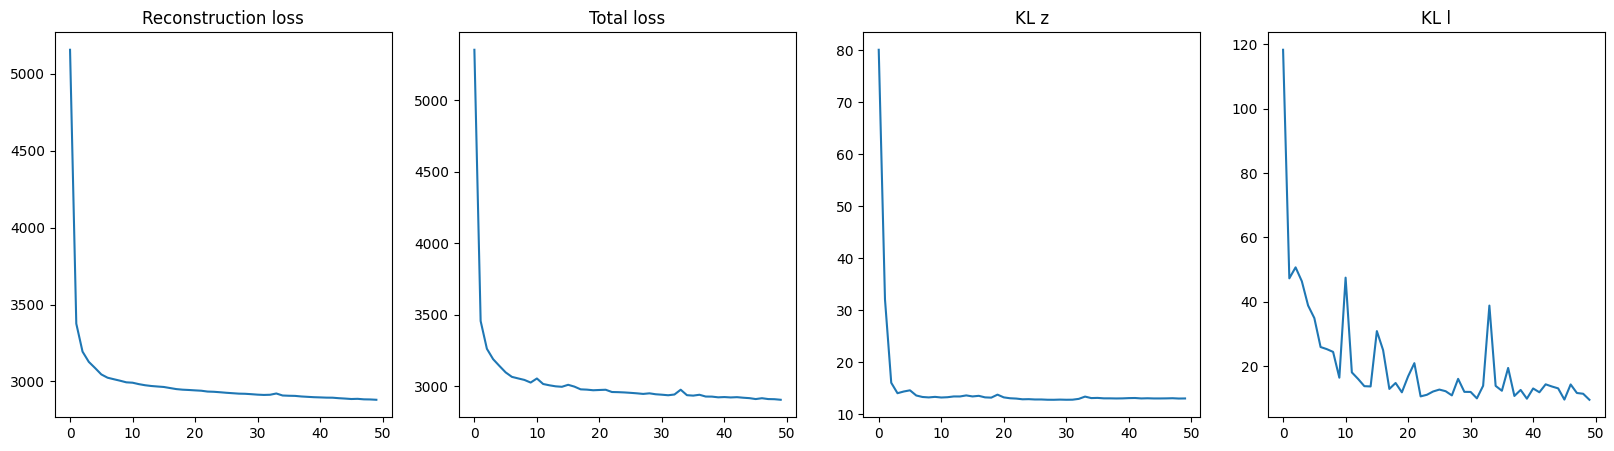

In [18]:
summary_plot(scRNA_cite_seq_history)

In [19]:
dataloader = DataLoader(scRNA_cite_seq_dataset, batch_size=128, shuffle=False)
scVI_rna_cite_seq_mu_z = predict_latents(best_scVI_rna_cite_seq_model, dataloader)
n_selection = 5000
np.random.seed(42)
idx_selected = np.random.choice(len(scVI_rna_cite_seq_mu_z), n_selection)
z_rna_cite_seq = get_tsne_embedding(scVI_rna_cite_seq_mu_z[idx_selected])

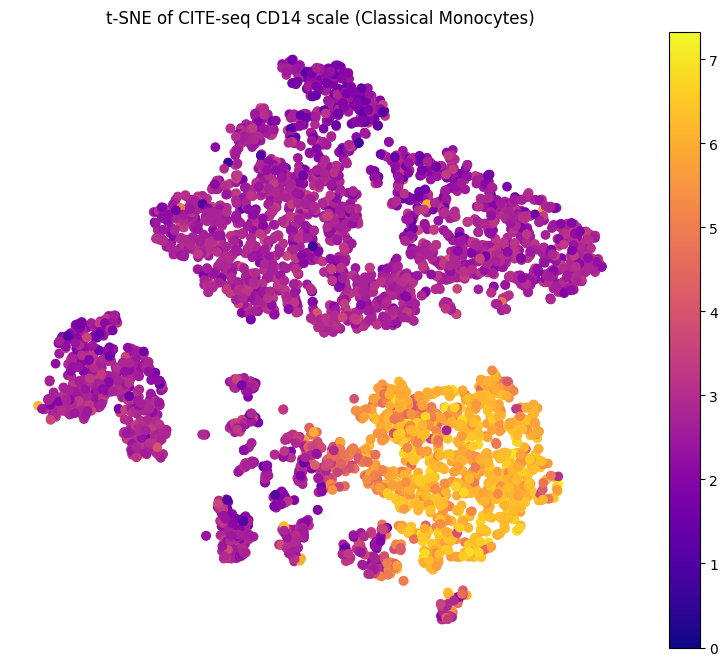

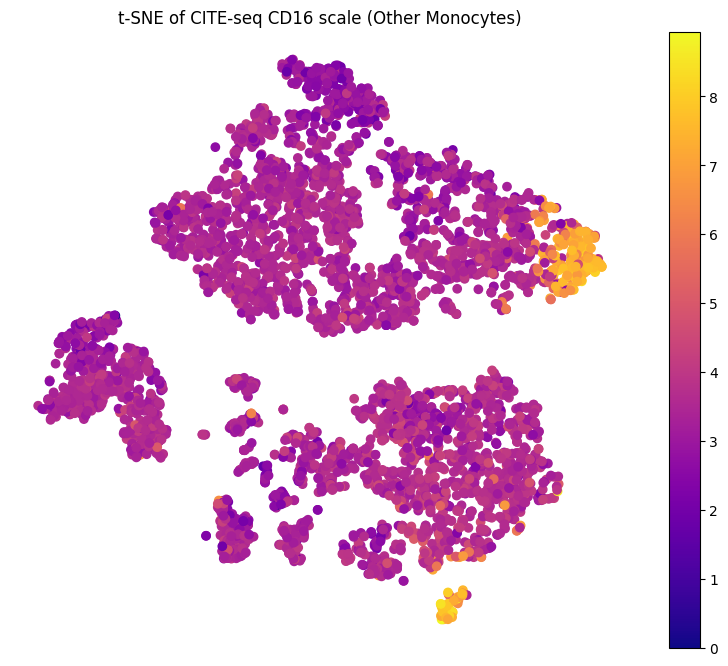

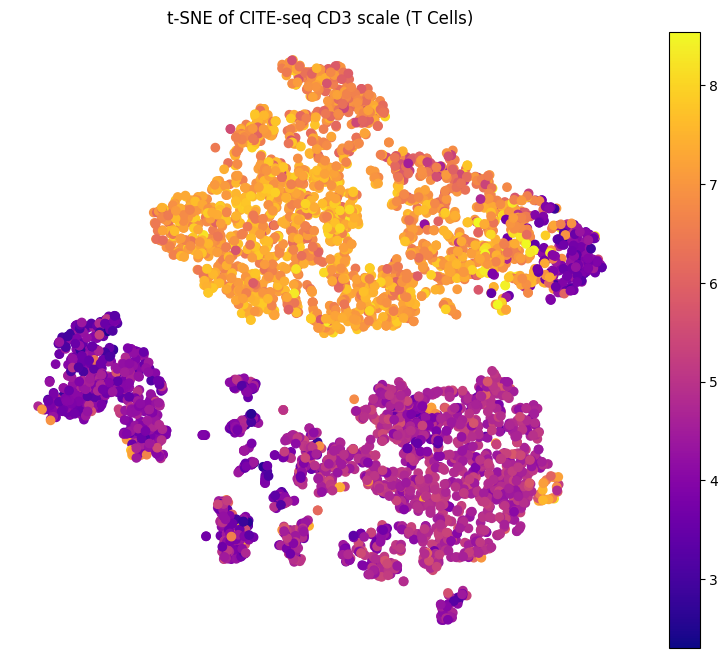

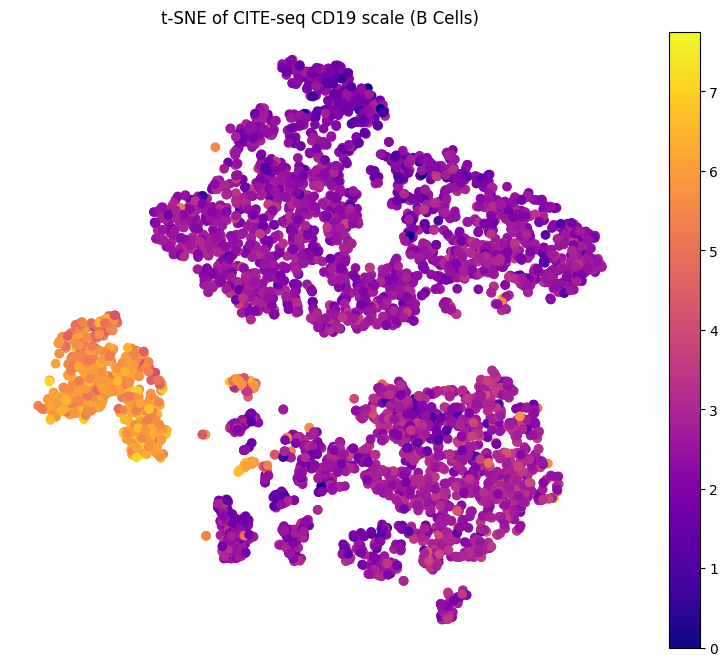

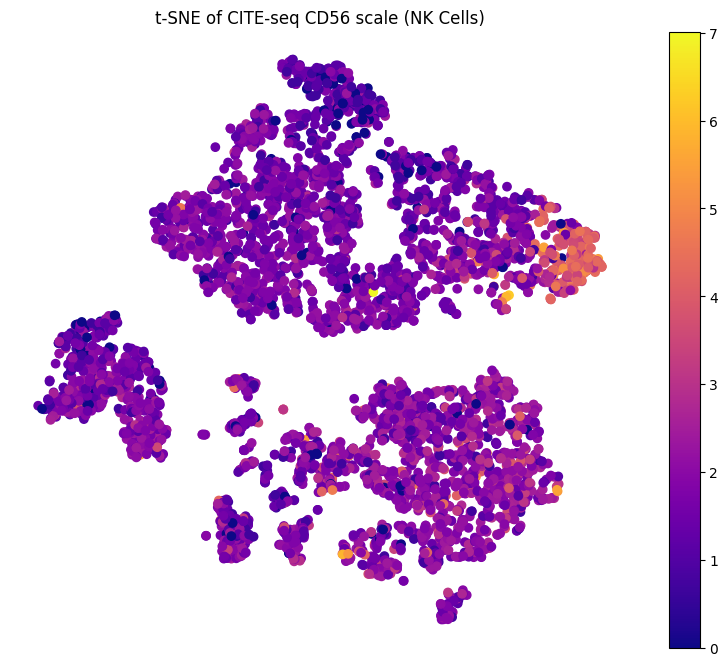

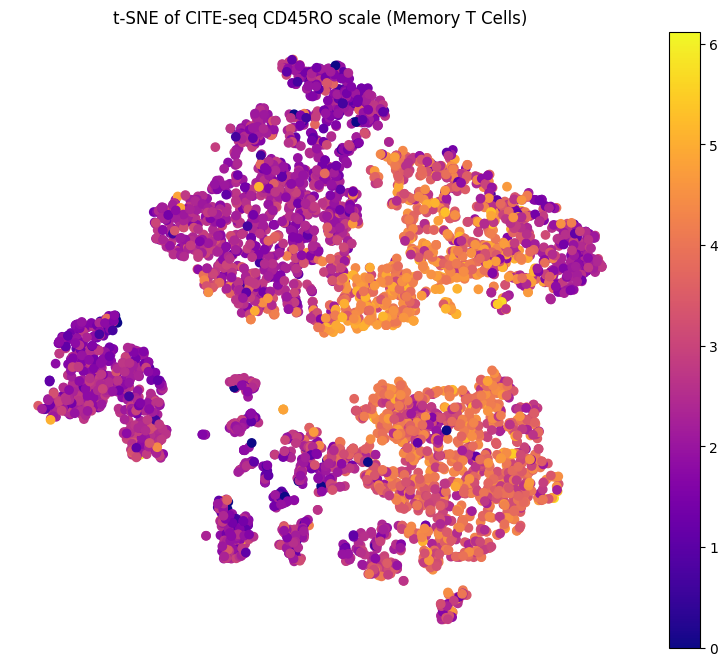

In [20]:
proteins_of_interest = {
    "CD14": "t-SNE of CITE-seq CD14 scale (Classical Monocytes)",
    "CD16": "t-SNE of CITE-seq CD16 scale (Other Monocytes)",
    "CD3": "t-SNE of CITE-seq CD3 scale (T Cells)",
    "CD19": "t-SNE of CITE-seq CD19 scale (B Cells)",
    "CD56": "t-SNE of CITE-seq CD56 scale (NK Cells)",
    "CD45RO": "t-SNE of CITE-seq CD45RO scale (Memory T Cells)"
}

for protein, title in proteins_of_interest.items():
    cd_scale = np.log(1+df[protein])
    tsne_cell_state_plot_with_scale(
        z_rna_cite_seq,
        cd_scale[idx_selected],
        title = title
    )

## CiteVI on CITE-seq data (RNA + proteins)

### Model training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cite_seq_loader = DataLoader(citeVI_dataset, batch_size=128, shuffle=True)

citeVI_model = CiteVI(
    n_genes = citeVI_dataset.X.shape[1],
    n_proteins = citeVI_dataset.Y.shape[1],
    n_batches = citeVI_dataset.n_batches,
    mu_l_batch = citeVI_dataset.mu_l_batch,
    var_l_batch = citeVI_dataset.var_l_batch,
    latent_dim = 15
)

In [22]:
cite_seq_history, cite_seq_best_state = fit(
    citeVI_model,
    cite_seq_loader,
    elbo_citevi,
    epochs = 50,
    lr = 1e-4
)

Epoch 1/50 | loss: 5406.7263 | recon_x: 5022.4111 | recon_y: 1895.1898 | kl_z: 96.6564 | kl_l: 98.1399
Epoch 2/50 | loss: 3479.4908 | recon_x: 3309.3320 | recon_y: 454.7017 | kl_z: 60.2130 | kl_l: 64.4756
Epoch 3/50 | loss: 3308.3925 | recon_x: 3179.9275 | recon_y: 312.0150 | kl_z: 38.1658 | kl_l: 59.0977
Epoch 4/50 | loss: 3258.1776 | recon_x: 3137.8613 | recon_y: 255.6740 | kl_z: 29.8595 | kl_l: 64.8894
Epoch 5/50 | loss: 3165.0090 | recon_x: 3078.6424 | recon_y: 225.7353 | kl_z: 26.9725 | kl_l: 36.8205
Epoch 6/50 | loss: 3128.9601 | recon_x: 3048.8850 | recon_y: 205.7559 | kl_z: 23.6741 | kl_l: 35.8254
Epoch 7/50 | loss: 3105.2218 | recon_x: 3031.0159 | recon_y: 191.9696 | kl_z: 20.7735 | kl_l: 34.2354
Epoch 8/50 | loss: 3086.9894 | recon_x: 3019.6314 | recon_y: 181.6532 | kl_z: 18.4412 | kl_l: 30.7515
Epoch 9/50 | loss: 3065.7488 | recon_x: 3011.2999 | recon_y: 174.2031 | kl_z: 16.9027 | kl_l: 20.1259
Epoch 10/50 | loss: 3068.1622 | recon_x: 3006.6648 | recon_y: 166.9355 | kl_z: 16

In [23]:
best_citeVI_model = CiteVI(
    n_genes = citeVI_dataset.X.shape[1],
    n_proteins = citeVI_dataset.Y.shape[1],
    n_batches = citeVI_dataset.n_batches,
    mu_l_batch = citeVI_dataset.mu_l_batch,
    var_l_batch = citeVI_dataset.var_l_batch,
    latent_dim = 15
).to(device)
best_citeVI_model.load_state_dict(cite_seq_best_state)

<All keys matched successfully>

In [24]:
count_n_params(best_citeVI_model)

Model has 8845773 trainable parameters


### Visualizations

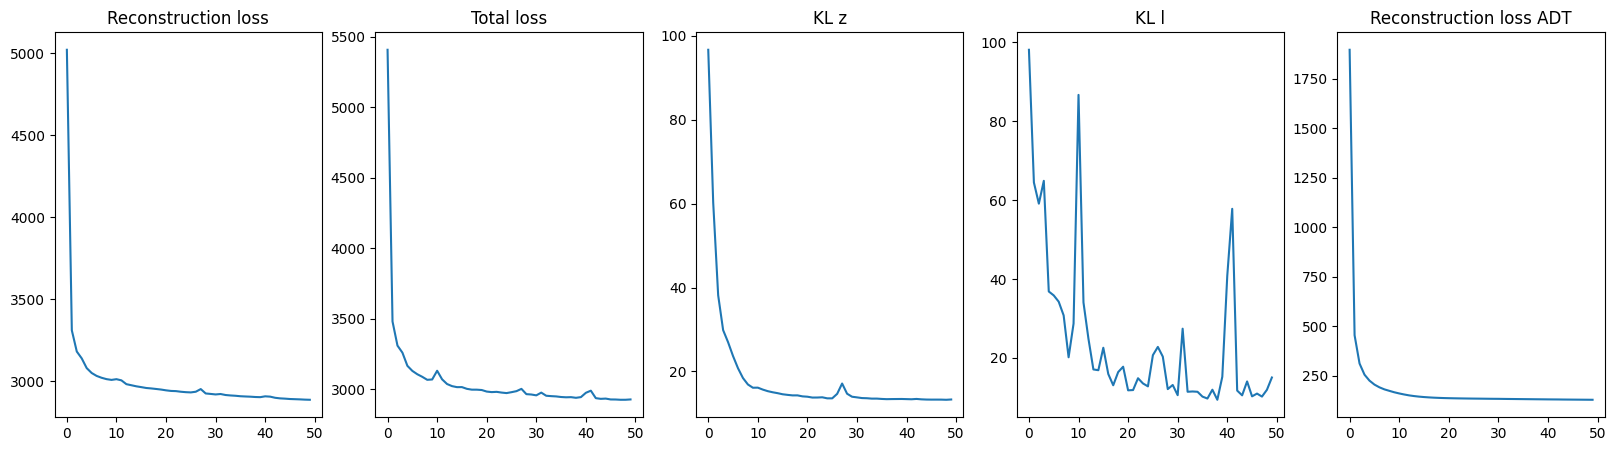

In [25]:
summary_plot(cite_seq_history)

In [26]:
dataloader = DataLoader(citeVI_dataset, batch_size=128, shuffle=False)
citeVI_mu_z = predict_latents(best_citeVI_model, dataloader)
n_selection = 5000
np.random.seed(42)
idx_selected = np.random.choice(len(citeVI_mu_z), n_selection)
z_cite_seq = get_tsne_embedding(citeVI_mu_z[idx_selected])

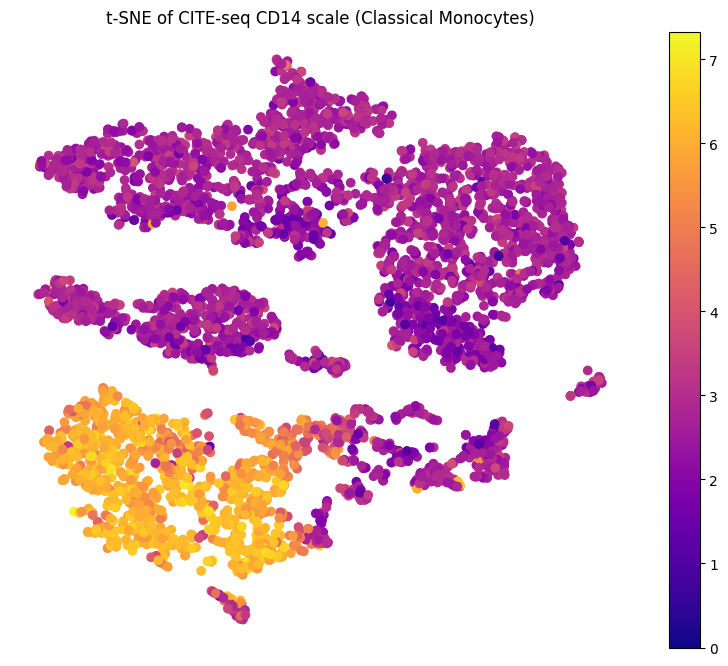

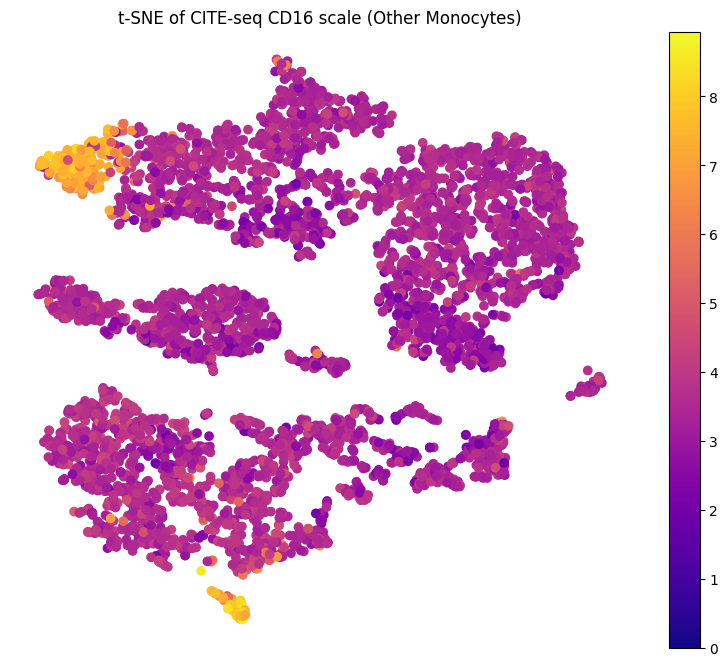

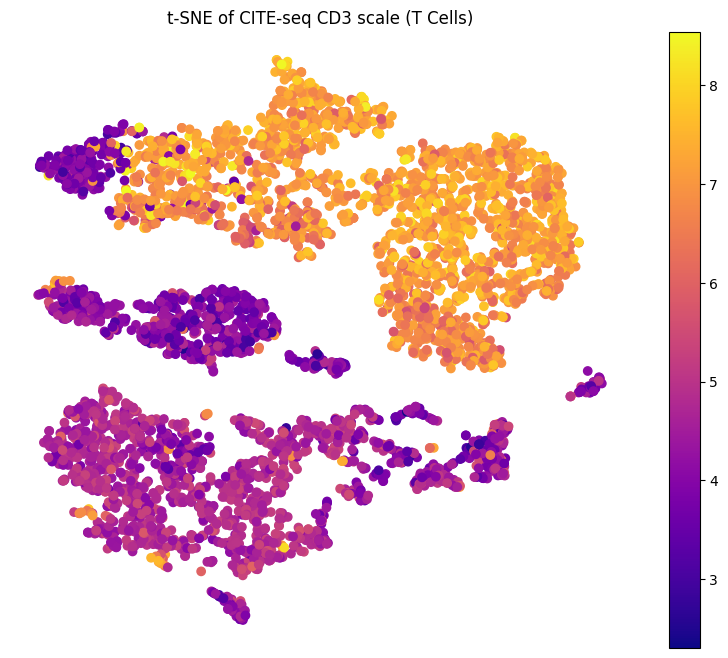

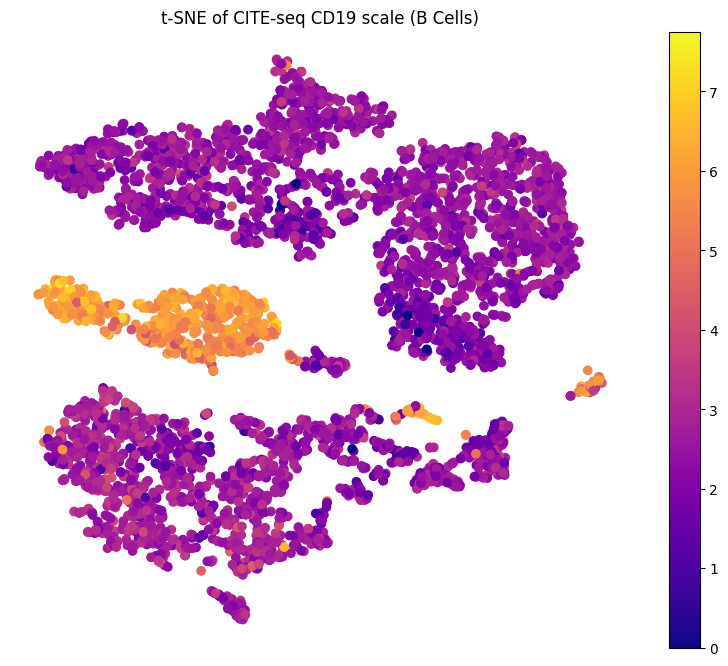

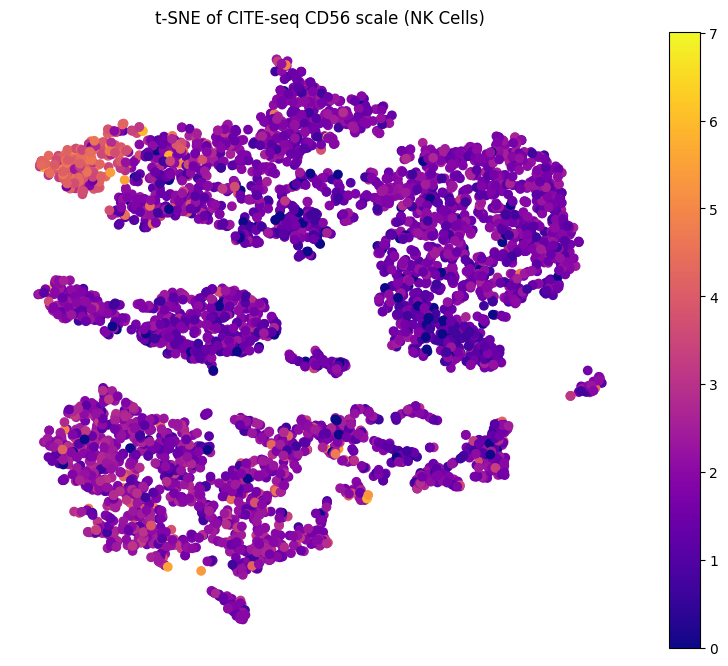

In [28]:
proteins_of_interest = {
    "CD14": "t-SNE of CITE-seq CD14 scale (Classical Monocytes)",
    "CD16": "t-SNE of CITE-seq CD16 scale (Other Monocytes)",
    "CD3": "t-SNE of CITE-seq CD3 scale (T Cells)",
    "CD19": "t-SNE of CITE-seq CD19 scale (B Cells)",
    "CD56": "t-SNE of CITE-seq CD56 scale (NK Cells)"
}

for protein, title in proteins_of_interest.items():
    cd_scale = np.log(1+df[protein])
    tsne_cell_state_plot_with_scale(
        z_cite_seq,
        cd_scale[idx_selected],
        title = title
    )

## Conclusions

- In both cases, the application of the scVI model to CITE-seq data shows that latent cell state representations seem to correlate strongly with some key CD proteins.
- Very interestingly, the scVI model trained on RNA CITE-seq data only captures already very well the cell-type variability of PBMCs.
- It is likely that meaningful cell-type-specific signal is already carried by the transcriptomic data.
- As a result, adding the proteomic data does not improve meaningfully the latent representations of the cell states.